In [ ]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# DATA LIBRARIES
import geopandas as gpd
import pandas as pd

# PREFERENCES
pd.set_option('display.max_columns', 500)
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'font.size': 14})

Define our Scikit-Learn Compliant Class so we can implement validation schemes within. Only two methods required: predict() and fit()

In [6]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred


Read CAMELS Data

In [ ]:
def getFeatureImportance(selector, testidx, input, output, xx, reps=10):
    # USING FULL PERMUTATION IMPORTANCE, AS OUTLINED IN 
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    result = permutation_importance(selector.rf, input.iloc[testidx, :], output.iloc[testidx], n_repeats=reps, random_state=42, n_jobs=2)
    means = pd.Series(result.importances_mean, index=list(input)) 
    std = pd.Series(result.importances_std, index=list(input))
    df = pd.concat([means, std], axis=1)
    df.columns = [str(xx) + "_mean", str(xx) + "_std"]
    return df


def runFitMetric(fitmet, axs, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\Repo\nextgen-form-eval\FrankTests\data\JonathanTests\\"
    perf_prefixes = ["daymet_time_split1", "daymet_time_split2", "nldas_time_split1", "nldas_time_split2"]
    perf_prefixes_abb = ["daymetS1", "daymetS2", "nldasS1", "nldasS2"]
    perf_metrics = [fitmet]

    # CONTAINER FOR PERFORMANCE VARIABLE NAMES
    perfvars = list()
    perfvars_split = list()


    # LOOP THROUGH EACH TO ADD TO CAMELS DATASET AND SAVE COLUMN NAME
    for i in range(0, len(perf_prefixes)):
        for ii in range(0, len(perf_metrics)):
            currdir = perf_dir + perf_prefixes[i] + "_" + perf_metrics[ii] + ".csv"
            currdf = pd.read_csv(currdir).add_prefix(perf_prefixes_abb[i] + "_" + perf_metrics[ii] + "_")
            first_col_name = currdf.columns.to_list()[0]
            perfvars.extend(currdf.columns.to_list()[1:])
            perfvars_split.append(currdf.columns.to_list()[1:])
            camels_df = camels_df.merge(currdf, how='right', left_on="hru_id", right_on=first_col_name)


    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']
    
    varstokeep = ['p_mean',
    'aridity',
    'high_prec_dur',
    'low_prec_freq']


    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perfvars]

    kf = KFold(n_splits=2, shuffle=True)
    # FIGURE
    # fig, axs = plt.subplots(len(perf_prefixes), 1, subplot_kw=dict(projection='3d'))

    axs[0].set_ylabel("Mean Absolute Error on " + fitmet)
    fig.tight_layout()

    fig1, axs2 = plt.subplots(len(perf_prefixes))

    for i in range(0, len(perf_prefixes)):

        # OUTPUT DATASETS FOR EACH SPLIT
        currout = outputdataset[perfvars_split[i]]

        # print(perf_prefixes[i])

        # VARS TO RETAIN FROM EACH SPLIT
        testvalues = np.zeros((inputdataset.shape[0], len(perfvars_split[i])))   # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
        modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
        test_modelno = np.zeros((inputdataset.shape[0], len(perfvars_split[i]))) # MODEL IN WHICH BASIN WAS IN TEST SET
        test_modellist = list()                                                  # MODEL CONTAINER
        featureimportance = list()

        # KFOLD SPLIT OF DATASETS
        for train, test in kf.split(inputdataset):
            print(train.shape)
            print(test.shape)
            
            # CODE FOR INDIVIDUAL MODEL TRAINING
            for ii in range(currout.shape[1]):
                # TRAIN MODEL ON TRAINING SET
                model = None
                model = ModelSelector(rf_kwargs=rf_kwargs)
                # model = make_pipeline(StandardScaler(), NuSVR(C=2, nu=0.05, tol=1e-3)) # svm.NuSVR()
                model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])
                train_pred = model.predict(inputdataset.iloc[train, :])
                # trainr2 = mse(train_pred, currout.iloc[train, ii].to_numpy())
                trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
                trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())
                plt.scatter(currout.iloc[train, ii], train_pred)

                #print("Train Dataset")
                #print(np.nanpercentile(currout.iloc[train, ii].to_numpy(), [0,25,50,75,100]))
                #print(train_pred[:5])
                #print(currout.iloc[train, ii].to_numpy()[:5])

                # PERFORM PREDICTION ON TEST SET
                model_pred = model.predict(inputdataset.iloc[test, :])
                testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
                testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())
                # plt.scatter(currout.iloc[test, ii], model_pred)
                # plt.show()
                # plt.close()
                
                #print("Test Dataset")
                #print(np.nanpercentile(currout.iloc[test, ii].to_numpy(), [0,25,50,75,100]))
                #print(model_pred[:5])
                #print(currout.iloc[test, ii].to_numpy()[:5])

                # GET FEATURE IMPORTANCE
                # fi = getFeatureImportance(model, test, inputdataset, currout.iloc[:,ii], modelno)

                # SAVE VALUES IN CONTAINERS ABOVE
                testvalues[test, ii] = model_pred
                test_modelno[test, ii] = modelno
                modelno = modelno + 1
                test_modellist.append(model)
                # featureimportance.append(fi)

                print(f"Training R2: {trainr2:.3f} | Test R2: {testr2} | Train RMSE: {trainrms:.3f} | Test RMSE: {testrms:.3f} | Model ID: {ii}")

        # CALCULATE ERROR OF DECISION SUPPORT
        pred_error = np.abs(testvalues - currout.to_numpy())
        

        if i == 0:
            minval = np.min(pred_error)
            maxval = np.max(pred_error)

        # PLOT
        axs[i].boxplot(pred_error, labels=["LSTM", "MC", "SAC"])
        axs[i].set_title(perf_prefixes_abb[i])
        axs[i].set_ylim(minval, maxval)
        # axs2[i].scatter(testvalues, currout.to_numpy())


    return axs, featureimportance

In [ ]:
fig, axs = plt.subplots(2,4, sharex='row')
rfargs =  {"n_estimators": 500}
axs[0, :], featureimportance = runFitMetric("KGE", axs[0, :], rf_kwargs=rfargs)
#axs[1, :] = runFitMetric("Alpha-NSE", axs[1, :])
#axs[2, :] = runFitMetric("Beta-NSE", axs[2, :])
#axs[3, :] = runFitMetric("MSE", axs[3, :])

In [ ]:
def getFeatureImportance(selector, testidx, input, output, xx, reps=10):
    # USING FULL PERMUTATION IMPORTANCE, AS OUTLINED IN 
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    result = permutation_importance(selector.rf, input.iloc[testidx, :], output.iloc[testidx], n_repeats=reps, random_state=42, n_jobs=2)
    means = pd.Series(result.importances_mean, index=list(input)) 
    std = pd.Series(result.importances_std, index=list(input))
    df = pd.concat([means, std], axis=1)
    df.columns = [str(xx) + "_mean", str(xx) + "_std"]
    return df


def runFitMetric(fitmet, axs, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\Repo\nextgen-form-eval\FrankTests\data\JonathanTests\\"
    perf_prefixes = ["daymet_time_split1", "daymet_time_split2", "nldas_time_split1", "nldas_time_split2"]
    perf_prefixes_abb = ["daymetS1", "daymetS2", "nldasS1", "nldasS2"]
    perf_metrics = [fitmet]

    # CONTAINER FOR PERFORMANCE VARIABLE NAMES
    perfvars = list()
    perfvars_split = list()


    # LOOP THROUGH EACH TO ADD TO CAMELS DATASET AND SAVE COLUMN NAME
    for i in range(0, len(perf_prefixes)):
        for ii in range(0, len(perf_metrics)):
            currdir = perf_dir + perf_prefixes[i] + "_" + perf_metrics[ii] + ".csv"
            currdf = pd.read_csv(currdir).add_prefix(perf_prefixes_abb[i] + "_" + perf_metrics[ii] + "_")
            first_col_name = currdf.columns.to_list()[0]
            perfvars.extend(currdf.columns.to_list()[1:])
            perfvars_split.append(currdf.columns.to_list()[1:])
            camels_df = camels_df.merge(currdf, how='right', left_on="hru_id", right_on=first_col_name)


    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']
    
    varstokeep = ['p_mean',
    'aridity',
    'high_prec_dur',
    'low_prec_freq']


    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perfvars]

    kf = KFold(n_splits=2, shuffle=True)
    # FIGURE
    # fig, axs = plt.subplots(len(perf_prefixes), 1, subplot_kw=dict(projection='3d'))

    axs[0].set_ylabel("Mean Absolute Error on " + fitmet)
    fig.tight_layout()

    fig1, axs2 = plt.subplots(len(perf_prefixes))

    for i in range(0, len(perf_prefixes)):

        # OUTPUT DATASETS FOR EACH SPLIT
        currout = outputdataset[perfvars_split[i]]

        # print(perf_prefixes[i])

        # VARS TO RETAIN FROM EACH SPLIT
        testvalues = np.zeros((inputdataset.shape[0], len(perfvars_split[i])))   # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
        modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
        test_modelno = np.zeros((inputdataset.shape[0], len(perfvars_split[i]))) # MODEL IN WHICH BASIN WAS IN TEST SET
        test_modellist = list()                                                  # MODEL CONTAINER
        featureimportance = list()

        # KFOLD SPLIT OF DATASETS
        for train, test in kf.split(inputdataset):
            print(train.shape)
            print(test.shape)
            
            # CODE FOR INDIVIDUAL MODEL TRAINING
            for ii in range(currout.shape[1]):
                # TRAIN MODEL ON TRAINING SET
                model = None
                model = ModelSelector(rf_kwargs=rf_kwargs)
                # model = make_pipeline(StandardScaler(), NuSVR(C=2, nu=0.05, tol=1e-3)) # svm.NuSVR()
                model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])
                train_pred = model.predict(inputdataset.iloc[train, :])
                # trainr2 = mse(train_pred, currout.iloc[train, ii].to_numpy())
                trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
                trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())
                plt.scatter(currout.iloc[train, ii], train_pred)

                #print("Train Dataset")
                #print(np.nanpercentile(currout.iloc[train, ii].to_numpy(), [0,25,50,75,100]))
                #print(train_pred[:5])
                #print(currout.iloc[train, ii].to_numpy()[:5])

                # PERFORM PREDICTION ON TEST SET
                model_pred = model.predict(inputdataset.iloc[test, :])
                testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
                testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())
                # plt.scatter(currout.iloc[test, ii], model_pred)
                # plt.show()
                # plt.close()
                
                #print("Test Dataset")
                #print(np.nanpercentile(currout.iloc[test, ii].to_numpy(), [0,25,50,75,100]))
                #print(model_pred[:5])
                #print(currout.iloc[test, ii].to_numpy()[:5])

                # GET FEATURE IMPORTANCE
                # fi = getFeatureImportance(model, test, inputdataset, currout.iloc[:,ii], modelno)

                # SAVE VALUES IN CONTAINERS ABOVE
                testvalues[test, ii] = model_pred
                test_modelno[test, ii] = modelno
                modelno = modelno + 1
                test_modellist.append(model)
                # featureimportance.append(fi)

                print(f"Training R2: {trainr2:.3f} | Test R2: {testr2:.3f} | Train RMSE: {trainrms:.3f} | Test RMSE: {testrms:.3f} | Model ID: {ii}")

        # CALCULATE ERROR OF DECISION SUPPORT
        pred_error = np.abs(testvalues - currout.to_numpy())
        

        if i == 0:
            minval = np.min(pred_error)
            maxval = np.max(pred_error)

        # PLOT
        axs[i].boxplot(pred_error, labels=["LSTM", "MC", "SAC"])
        axs[i].set_title(perf_prefixes_abb[i])
        axs[i].set_ylim(minval, maxval)
        # axs2[i].scatter(testvalues, currout.to_numpy())


    return axs, featureimportance

In [29]:
def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\Repo\nextgen-form-eval\FrankTests\data\JonathanTests\\"
    # perf_prefixes = ["daymet_time_split1", "daymet_time_split2", "nldas_time_split1", "nldas_time_split2"]
    perf_prefixes = ["daymet_time_split1"]
    perf_prefixes_abb = ["daymetS1", "daymetS2", "nldasS1", "nldasS2"]
    perf_metrics = [fitmet]

    # CONTAINER FOR PERFORMANCE VARIABLE NAMES
    perfvars = list()
    perfvars_split = list()


    # LOOP THROUGH EACH TO ADD TO CAMELS DATASET AND SAVE COLUMN NAME
    for i in range(0, len(perf_prefixes)):
        for ii in range(0, len(perf_metrics)):
            currdir = perf_dir + perf_prefixes[i] + "_" + perf_metrics[ii] + ".csv"
            currdf = pd.read_csv(currdir).add_prefix(perf_prefixes_abb[i] + "_" + perf_metrics[ii] + "_")
            first_col_name = currdf.columns.to_list()[0]
            perfvars.extend(currdf.columns.to_list()[1:])
            perfvars_split.append(currdf.columns.to_list()[1:])
            camels_df = camels_df.merge(currdf, how='right', left_on="hru_id", right_on=first_col_name)


    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']


    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perfvars]

    kf = KFold(n_splits=5, shuffle=True)
    inputdataset, xmetatest, outputdataset, ymetatest = train_test_split(inputdataset, outputdataset, test_size=0.20, random_state=42)

    for i in range(0, len(perf_prefixes)):

        # OUTPUT DATASETS FOR EACH SPLIT
        currout = outputdataset[perfvars_split[i]]

        # print(perf_prefixes[i])

        # VARS TO RETAIN FROM EACH SPLIT
        testvalues = np.zeros((inputdataset.shape[0], len(perfvars_split[i])))   # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
        modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
        test_modelno = np.zeros((inputdataset.shape[0], len(perfvars_split[i]))) # MODEL IN WHICH BASIN WAS IN TEST SET
        test_modellist = list()                                                  # MODEL CONTAINER
        featureimportance = list()
        msetest = list()
        msetrain = list()
        msemeta = list()

        # KFOLD SPLIT OF DATASETS
        for train, test in kf.split(inputdataset):            
            # CODE FOR INDIVIDUAL MODEL TRAINING
            for ii in range(currout.shape[1]):
                # TRAIN MODEL ON TRAINING SET
                model = None
                model = ModelSelector(rf_kwargs=rf_kwargs)
                model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

                # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
                train_pred = model.predict(inputdataset.iloc[train, :])
                trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
                trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

                # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
                model_pred = model.predict(inputdataset.iloc[test, :])
                testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
                testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())

                # PERFORM PREDICTION ON METATEST SET AND GET FIT METRICS
                meta_pred = model.predict(xmetatest)
                metarms = mse(meta_pred, ymetatest.iloc[:, ii].to_numpy())
                metar2 = r2_score(meta_pred, ymetatest.iloc[:, ii].to_numpy())

                # SAVE VALUES IN CONTAINERS ABOVE
                testvalues[test, ii] = model_pred
                test_modelno[test, ii] = modelno
                modelno = modelno + 1
                test_modellist.append(model)
                msetest.append(testrms)
                msetrain.append(trainrms)
                msemeta.append(metarms)

                # print(f"Training R2: {trainr2:.3f} | Test R2: {testr2:.3f} | Train MSE: {trainrms:.3f} | Test MSE: {testrms:.3f} | Model ID: {ii}")
                print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")

        # CALCULATE ERROR OF DECISION SUPPORT
        pred_error = np.abs(testvalues - currout.to_numpy())
        

        if i == 0:
            minval = np.min(pred_error)
            maxval = np.max(pred_error)


    return msetrain, msetest, msemeta

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -1.650 | Meta R2: -0.921 | Test MSE: 0.040 | Meta MSE: 0.041 | Model ID: 0
Test R2: -0.201 | Meta R2: -1.067 | Test MSE: 0.030 | Meta MSE: 0.042 | Model ID: 1
Test R2: -0.798 | Meta R2: -0.763 | Test MSE: 0.037 | Meta MSE: 0.052 | Model ID: 2
Test R2: -0.568 | Meta R2: -0.718 | Test MSE: 0.042 | Meta MSE: 0.052 | Model ID: 0
Test R2: -0.420 | Meta R2: -0.881 | Test MSE: 0.044 | Meta MSE: 0.053 | Model ID: 1
Test R2: -0.957 | Meta R2: -1.187 | Test MSE: 0.046 | Meta MSE: 0.041 | Model ID: 2
Test R2: -1.791 | Meta R2: -0.512 | Test MSE: 0.044 | Meta MSE: 0.066 | Model ID: 0
Test R2: -0.192 | Meta R2: -0.517 | Test MSE: 0.037 | Meta MSE: 0.036 | Model ID: 1
Test R2: -0.491 | Meta R2: -0.509 | Test MSE: 0.036 | Meta MSE: 0.055 | Model ID: 2
Test R2: 0.111 | Meta R2: 0.009 | Test MSE: 0.059 | Meta MSE: 0.064 | Model ID: 0
Test R2: -0.416 | Meta R2: -1.355 | Test MSE: 0.031 | Meta MSE: 0.049 | Model ID: 1
Test R2: -0.116 | Meta R2: -0.387 | Test MSE: 0.033 | Meta MSE: 0.044 | Model 

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -0.972 | Meta R2: -1.016 | Test MSE: 0.033 | Meta MSE: 0.035 | Model ID: 0
Test R2: -1.212 | Meta R2: -1.484 | Test MSE: 0.023 | Meta MSE: 0.035 | Model ID: 1
Test R2: -1.658 | Meta R2: -1.087 | Test MSE: 0.025 | Meta MSE: 0.028 | Model ID: 2
Test R2: -1.305 | Meta R2: -1.088 | Test MSE: 0.037 | Meta MSE: 0.038 | Model ID: 0
Test R2: -2.278 | Meta R2: -2.375 | Test MSE: 0.036 | Meta MSE: 0.036 | Model ID: 1
Test R2: -2.407 | Meta R2: -3.329 | Test MSE: 0.035 | Meta MSE: 0.035 | Model ID: 2
Test R2: -1.624 | Meta R2: -1.122 | Test MSE: 0.031 | Meta MSE: 0.027 | Model ID: 0
Test R2: -1.934 | Meta R2: -1.622 | Test MSE: 0.026 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.752 | Meta R2: -1.089 | Test MSE: 0.022 | Meta MSE: 0.032 | Model ID: 2
Test R2: 0.053 | Meta R2: -1.113 | Test MSE: 0.024 | Meta MSE: 0.030 | Model ID: 0
Test R2: -0.469 | Meta R2: -1.137 | Test MSE: 0.034 | Meta MSE: 0.036 | Model ID: 1
Test R2: -0.364 | Meta R2: -1.515 | Test MSE: 0.027 | Meta MSE: 0.037 | Model

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -2.327 | Meta R2: -1.682 | Test MSE: 0.032 | Meta MSE: 0.028 | Model ID: 0
Test R2: -0.612 | Meta R2: -1.474 | Test MSE: 0.019 | Meta MSE: 0.032 | Model ID: 1
Test R2: -0.685 | Meta R2: -2.236 | Test MSE: 0.019 | Meta MSE: 0.031 | Model ID: 2
Test R2: -2.489 | Meta R2: -1.489 | Test MSE: 0.036 | Meta MSE: 0.026 | Model ID: 0
Test R2: -1.384 | Meta R2: -2.383 | Test MSE: 0.025 | Meta MSE: 0.032 | Model ID: 1
Test R2: -1.139 | Meta R2: -2.308 | Test MSE: 0.027 | Meta MSE: 0.034 | Model ID: 2
Test R2: -0.277 | Meta R2: -2.214 | Test MSE: 0.022 | Meta MSE: 0.032 | Model ID: 0
Test R2: -1.163 | Meta R2: -1.748 | Test MSE: 0.027 | Meta MSE: 0.036 | Model ID: 1
Test R2: -0.765 | Meta R2: -1.602 | Test MSE: 0.022 | Meta MSE: 0.037 | Model ID: 2
Test R2: -1.169 | Meta R2: -0.957 | Test MSE: 0.029 | Meta MSE: 0.034 | Model ID: 0
Test R2: -1.082 | Meta R2: -2.421 | Test MSE: 0.026 | Meta MSE: 0.036 | Model ID: 1
Test R2: -1.464 | Meta R2: -3.086 | Test MSE: 0.027 | Meta MSE: 0.035 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: 0.027 | Meta R2: -1.041 | Test MSE: 0.014 | Meta MSE: 0.030 | Model ID: 0
Test R2: -0.684 | Meta R2: -2.282 | Test MSE: 0.017 | Meta MSE: 0.032 | Model ID: 1
Test R2: -0.239 | Meta R2: -1.799 | Test MSE: 0.015 | Meta MSE: 0.034 | Model ID: 2
Test R2: -0.441 | Meta R2: -1.467 | Test MSE: 0.021 | Meta MSE: 0.031 | Model ID: 0
Test R2: -1.206 | Meta R2: -1.979 | Test MSE: 0.028 | Meta MSE: 0.031 | Model ID: 1
Test R2: -1.196 | Meta R2: -1.756 | Test MSE: 0.028 | Meta MSE: 0.033 | Model ID: 2
Test R2: -1.554 | Meta R2: -2.139 | Test MSE: 0.028 | Meta MSE: 0.030 | Model ID: 0
Test R2: -1.293 | Meta R2: -2.090 | Test MSE: 0.023 | Meta MSE: 0.036 | Model ID: 1
Test R2: -1.767 | Meta R2: -1.861 | Test MSE: 0.025 | Meta MSE: 0.034 | Model ID: 2
Test R2: -1.704 | Meta R2: -1.884 | Test MSE: 0.034 | Meta MSE: 0.026 | Model ID: 0
Test R2: -1.554 | Meta R2: -2.641 | Test MSE: 0.024 | Meta MSE: 0.032 | Model ID: 1
Test R2: -1.136 | Meta R2: -2.289 | Test MSE: 0.028 | Meta MSE: 0.033 | Model

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -2.311 | Meta R2: -1.646 | Test MSE: 0.015 | Meta MSE: 0.028 | Model ID: 0
Test R2: -1.437 | Meta R2: -2.013 | Test MSE: 0.020 | Meta MSE: 0.031 | Model ID: 1
Test R2: -1.836 | Meta R2: -2.712 | Test MSE: 0.018 | Meta MSE: 0.031 | Model ID: 2
Test R2: -1.827 | Meta R2: -1.364 | Test MSE: 0.026 | Meta MSE: 0.033 | Model ID: 0
Test R2: -0.500 | Meta R2: -2.456 | Test MSE: 0.018 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.677 | Meta R2: -1.894 | Test MSE: 0.019 | Meta MSE: 0.034 | Model ID: 2
Test R2: -0.379 | Meta R2: -0.950 | Test MSE: 0.022 | Meta MSE: 0.029 | Model ID: 0
Test R2: -2.138 | Meta R2: -2.347 | Test MSE: 0.028 | Meta MSE: 0.035 | Model ID: 1
Test R2: -1.339 | Meta R2: -2.193 | Test MSE: 0.029 | Meta MSE: 0.033 | Model ID: 2
Test R2: -1.239 | Meta R2: -2.421 | Test MSE: 0.028 | Meta MSE: 0.033 | Model ID: 0
Test R2: -0.882 | Meta R2: -1.852 | Test MSE: 0.019 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.909 | Meta R2: -2.456 | Test MSE: 0.020 | Meta MSE: 0.032 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -1.628 | Meta R2: -1.471 | Test MSE: 0.028 | Meta MSE: 0.029 | Model ID: 0
Test R2: -1.023 | Meta R2: -2.250 | Test MSE: 0.022 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.922 | Meta R2: -2.544 | Test MSE: 0.021 | Meta MSE: 0.034 | Model ID: 2
Test R2: -0.247 | Meta R2: -1.077 | Test MSE: 0.034 | Meta MSE: 0.030 | Model ID: 0
Test R2: -0.741 | Meta R2: -2.202 | Test MSE: 0.025 | Meta MSE: 0.034 | Model ID: 1
Test R2: -0.897 | Meta R2: -1.860 | Test MSE: 0.024 | Meta MSE: 0.033 | Model ID: 2
Test R2: -0.520 | Meta R2: -1.538 | Test MSE: 0.025 | Meta MSE: 0.033 | Model ID: 0
Test R2: -1.175 | Meta R2: -2.263 | Test MSE: 0.028 | Meta MSE: 0.031 | Model ID: 1
Test R2: -1.743 | Meta R2: -1.879 | Test MSE: 0.027 | Meta MSE: 0.033 | Model ID: 2
Test R2: -0.199 | Meta R2: -1.317 | Test MSE: 0.015 | Meta MSE: 0.031 | Model ID: 0
Test R2: -1.971 | Meta R2: -2.867 | Test MSE: 0.023 | Meta MSE: 0.034 | Model ID: 1
Test R2: -1.488 | Meta R2: -2.467 | Test MSE: 0.023 | Meta MSE: 0.032 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -2.601 | Meta R2: -1.606 | Test MSE: 0.037 | Meta MSE: 0.027 | Model ID: 0
Test R2: -0.053 | Meta R2: -2.124 | Test MSE: 0.013 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.074 | Meta R2: -1.746 | Test MSE: 0.015 | Meta MSE: 0.033 | Model ID: 2
Test R2: -0.953 | Meta R2: -1.478 | Test MSE: 0.026 | Meta MSE: 0.029 | Model ID: 0
Test R2: -0.732 | Meta R2: -1.672 | Test MSE: 0.020 | Meta MSE: 0.031 | Model ID: 1
Test R2: -0.792 | Meta R2: -1.612 | Test MSE: 0.021 | Meta MSE: 0.031 | Model ID: 2
Test R2: -0.941 | Meta R2: -2.218 | Test MSE: 0.017 | Meta MSE: 0.028 | Model ID: 0
Test R2: -1.176 | Meta R2: -2.447 | Test MSE: 0.019 | Meta MSE: 0.031 | Model ID: 1
Test R2: -0.799 | Meta R2: -1.831 | Test MSE: 0.020 | Meta MSE: 0.030 | Model ID: 2
Test R2: -0.605 | Meta R2: -1.956 | Test MSE: 0.020 | Meta MSE: 0.029 | Model ID: 0
Test R2: -1.801 | Meta R2: -1.697 | Test MSE: 0.027 | Meta MSE: 0.034 | Model ID: 1
Test R2: -1.996 | Meta R2: -2.300 | Test MSE: 0.024 | Meta MSE: 0.033 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -3.086 | Meta R2: -1.625 | Test MSE: 0.024 | Meta MSE: 0.029 | Model ID: 0
Test R2: -3.205 | Meta R2: -3.803 | Test MSE: 0.026 | Meta MSE: 0.033 | Model ID: 1
Test R2: -2.913 | Meta R2: -2.673 | Test MSE: 0.023 | Meta MSE: 0.033 | Model ID: 2
Test R2: -1.978 | Meta R2: -1.835 | Test MSE: 0.025 | Meta MSE: 0.030 | Model ID: 0
Test R2: -1.509 | Meta R2: -2.484 | Test MSE: 0.022 | Meta MSE: 0.034 | Model ID: 1
Test R2: -1.321 | Meta R2: -2.011 | Test MSE: 0.023 | Meta MSE: 0.031 | Model ID: 2
Test R2: -0.769 | Meta R2: -1.761 | Test MSE: 0.045 | Meta MSE: 0.028 | Model ID: 0
Test R2: -0.918 | Meta R2: -2.196 | Test MSE: 0.030 | Meta MSE: 0.034 | Model ID: 1
Test R2: -0.825 | Meta R2: -2.293 | Test MSE: 0.032 | Meta MSE: 0.034 | Model ID: 2
Test R2: -1.178 | Meta R2: -1.536 | Test MSE: 0.030 | Meta MSE: 0.028 | Model ID: 0
Test R2: -0.239 | Meta R2: -2.057 | Test MSE: 0.012 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.304 | Meta R2: -2.366 | Test MSE: 0.014 | Meta MSE: 0.032 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -1.566 | Meta R2: -1.652 | Test MSE: 0.036 | Meta MSE: 0.029 | Model ID: 0
Test R2: -1.260 | Meta R2: -2.648 | Test MSE: 0.026 | Meta MSE: 0.034 | Model ID: 1
Test R2: -1.362 | Meta R2: -2.048 | Test MSE: 0.026 | Meta MSE: 0.033 | Model ID: 2
Test R2: -1.092 | Meta R2: -1.896 | Test MSE: 0.035 | Meta MSE: 0.029 | Model ID: 0
Test R2: -1.579 | Meta R2: -2.186 | Test MSE: 0.023 | Meta MSE: 0.033 | Model ID: 1
Test R2: -1.074 | Meta R2: -2.002 | Test MSE: 0.023 | Meta MSE: 0.033 | Model ID: 2
Test R2: -0.885 | Meta R2: -1.285 | Test MSE: 0.028 | Meta MSE: 0.032 | Model ID: 0
Test R2: -1.101 | Meta R2: -2.034 | Test MSE: 0.023 | Meta MSE: 0.033 | Model ID: 1
Test R2: -0.955 | Meta R2: -1.582 | Test MSE: 0.022 | Meta MSE: 0.032 | Model ID: 2
Test R2: -1.790 | Meta R2: -2.261 | Test MSE: 0.023 | Meta MSE: 0.027 | Model ID: 0
Test R2: -3.090 | Meta R2: -3.136 | Test MSE: 0.027 | Meta MSE: 0.032 | Model ID: 1
Test R2: -2.485 | Meta R2: -2.642 | Test MSE: 0.026 | Meta MSE: 0.032 | Mode

c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Test R2: -2.114 | Meta R2: -1.284 | Test MSE: 0.033 | Meta MSE: 0.028 | Model ID: 0
Test R2: -1.492 | Meta R2: -1.907 | Test MSE: 0.024 | Meta MSE: 0.033 | Model ID: 1
Test R2: -1.487 | Meta R2: -2.136 | Test MSE: 0.024 | Meta MSE: 0.033 | Model ID: 2
Test R2: -0.214 | Meta R2: -1.521 | Test MSE: 0.021 | Meta MSE: 0.028 | Model ID: 0
Test R2: -0.509 | Meta R2: -2.059 | Test MSE: 0.018 | Meta MSE: 0.030 | Model ID: 1
Test R2: -0.306 | Meta R2: -1.977 | Test MSE: 0.017 | Meta MSE: 0.032 | Model ID: 2
Test R2: -0.576 | Meta R2: -1.686 | Test MSE: 0.022 | Meta MSE: 0.030 | Model ID: 0
Test R2: -0.808 | Meta R2: -2.335 | Test MSE: 0.025 | Meta MSE: 0.031 | Model ID: 1
Test R2: -0.987 | Meta R2: -2.955 | Test MSE: 0.026 | Meta MSE: 0.033 | Model ID: 2
Test R2: -2.368 | Meta R2: -1.993 | Test MSE: 0.031 | Meta MSE: 0.032 | Model ID: 0
Test R2: -2.372 | Meta R2: -2.674 | Test MSE: 0.028 | Meta MSE: 0.035 | Model ID: 1
Test R2: -1.862 | Meta R2: -2.088 | Test MSE: 0.029 | Meta MSE: 0.035 | Mode

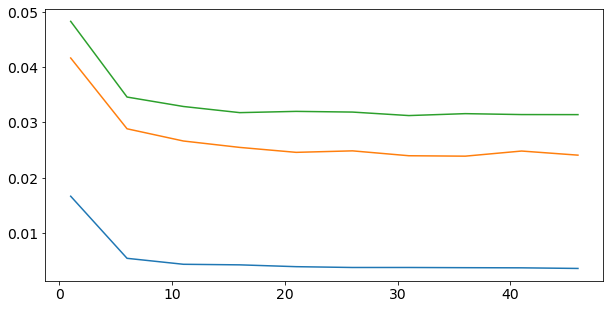

In [30]:
plt.rcParams['figure.figsize'] = (10, 5)

n_est = np.arange(1,51,5)
outmse_train = list()
outmse_test = list()
outmse_meta = list()

for i in n_est:
    rfargs =  {"n_estimators": i}
    currmse_train, currmse_test, currmse_meta = runFitMetric_getMSE("KGE",rf_kwargs=rfargs)
    outmse_train.append(np.mean(np.array(currmse_train)))
    outmse_test.append(np.mean(np.array(currmse_test)))
    outmse_meta.append(np.mean(np.array(currmse_meta)))

plt.plot(n_est, outmse_train)
plt.plot(n_est, outmse_test)
plt.plot(n_est, outmse_meta)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

n_est = 15
max_depth = np.arange(5, 100, 5)
outmse_train = list()
outmse_test = list()

for i in max_depth:
    rfargs =  {"n_estimators": n_est, "max_depth": i}
    currmse_train, currmse_test = runFitMetric_getMSE("KGE",rf_kwargs=rfargs)
    outmse_train.append(np.mean(np.array(currmse_train)))
    outmse_test.append(np.mean(np.array(currmse_test)))

plt.plot(max_depth, outmse_train)
plt.plot(max_depth, outmse_test)

In [ ]:
perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"

# READ ALL CSV FILES IN DIRECTORY
os.chdir(perf_dir)
modelfiles = glob.glob("*.csv")

# GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
# GET COLUMN NAME CONTAINING "BASIN"
fcol = [col for col in perf.columns if 'basin' in col]

# LOOP FOR EACH CSV FILE
for ii in range(1, len(modelfiles)):
    # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

    # GET COLUMN NAME CONTAINING "BASIN"
    basin_col= [col for col in currdf.columns if 'basin' in col]
    # JOIN ON MATCHING BASINS
    perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)

# Change to variable name
outputdataset = perf


In [1]:
def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)

    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in currdf.columns if fitmet in col]



    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)
    inputdataset, xmetatest, outputdataset, ymetatest = train_test_split(inputdataset, outputdataset, test_size=0.20, random_state=42)


    testvalues = np.zeros((inputdataset.shape[0], nsplits))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], nsplits))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    msetest = list()
    msetrain = list()
    msemeta = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            # print(train_pred)
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())

            # PERFORM PREDICTION ON METATEST SET AND GET FIT METRICS
            meta_pred = model.predict(xmetatest)
            metarms = mse(meta_pred, ymetatest.iloc[:, ii].to_numpy())
            metar2 = r2_score(meta_pred, ymetatest.iloc[:, ii].to_numpy())

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)
            msemeta.append(metarms)

            print(testrms)

            # print(f"Training R2: {trainr2:.3f} | Test R2: {testr2:.3f} | Train MSE: {trainrms:.3f} | Test MSE: {testrms:.3f} | Model ID: {ii}")
            print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")


    return msetrain, msetest, msemeta

In [2]:
rfargs =  {"n_estimators": 25}
msetrain, msetest, msemeta = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)

NameError: name 'gpd' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

n_est = 15
max_depth = np.arange(5, 100, 5)
outmse_train = list()
outmse_test = list()

for i in max_depth:
    rfargs =  {"n_estimators": n_est, "max_depth": i}
    currmse_train, currmse_test = runFitMetric_getMSE("KGE",rf_kwargs=rfargs)
    outmse_train.append(np.mean(np.array(currmse_train)))
    outmse_test.append(np.mean(np.array(currmse_test)))

plt.plot(max_depth, outmse_train)
plt.plot(max_depth, outmse_test)

In [ ]:

fig, axs = plt.subplots(3,3)
axs[0][0].plot(inputdataset['aridity'], outputdataset['daymetS1_KGE_lstm'], '.k')
axs[0][1].plot(inputdataset['high_prec_dur'], outputdataset['daymetS1_KGE_lstm'], '.k')
axs[0][2].plot(inputdataset['low_prec_freq'], outputdataset['daymetS1_KGE_lstm'], '.k')

axs[1][0].plot(inputdataset['aridity'], outputdataset['daymetS1_KGE_mc'], '.k')
axs[1][1].plot(inputdataset['high_prec_dur'], outputdataset['daymetS1_KGE_mc'], '.k')
axs[1][2].plot(inputdataset['low_prec_freq'], outputdataset['daymetS1_KGE_mc'], '.k')

axs[2][0].plot(inputdataset['aridity'], outputdataset['daymetS1_KGE_sac'], '.k')
axs[2][1].plot(inputdataset['high_prec_dur'], outputdataset['daymetS1_KGE_sac'], '.k')
axs[2][2].plot(inputdataset['low_prec_freq'], outputdataset['daymetS1_KGE_sac'], '.k')


